In [1]:
import torch
import lovely_tensors as lt
lt.monkey_patch()

from datasets import load_dataset
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

/Users/phani/Work/Adhoc/projects/learning-ai/learn-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notebook objectives
1. Obtain a standard text dataset from huggingface
2. Use RNN for text classification
3. Use LSTM for text classification
4. Use GRU for text classification

# Download the dataset

In [2]:
data_hf = load_dataset("google-research-datasets/go_emotions")
data_hf

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

In [3]:
labels = data_hf['train'].features['labels'].feature.names
print(len(labels))
print({i:l for i, l in enumerate(labels)})

28
{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


There are approx 43k rows in train set and 5k rows in each of validation set and test set. There are 28 labels in our dataset.

In [4]:
data_hf['train'].to_pandas()

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj
...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,[18],edsb738
43406,Always thought that was funny but is it a refe...,[6],ee7fdou
43407,What are you talking about? Anything bad that ...,[3],efgbhks
43408,"More like a baptism, with sexy results!",[13],ed1naf8


In [5]:
train_y = [x[0] for x in data_hf['train']['labels']]
val_y = [x[0] for x in data_hf['validation']['labels']]
test_y = [x[0] for x in data_hf['test']['labels']]

In [6]:
# Text preprocessing and tokenization
from collections import Counter
import numpy as np

class TextDataProcessor:
    def __init__(self, vocab_size=10000, max_length=128):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_built = False
        
    def build_vocab(self, texts):
        """Build vocabulary from training texts"""
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)
        
        # Keep most frequent words
        most_common = word_counts.most_common(self.vocab_size - 2)  # -2 for PAD and UNK
        
        # Build mappings
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        
        for i, (word, _) in enumerate(most_common, start=2):
            self.word_to_idx[word] = i
            self.idx_to_word[i] = word
            
        self.vocab_built = True
        
    def text_to_indices(self, text):
        """Convert text to sequence of indices"""
        words = text.lower().split()
        indices = []
        for word in words:
            idx = self.word_to_idx.get(word, 1)  # 1 is UNK token
            indices.append(idx)
        
        # Pad or truncate to max_length
        if len(indices) < self.max_length:
            indices.extend([0] * (self.max_length - len(indices)))
        else:
            indices = indices[:self.max_length]
            
        return indices

# Process the go_emotions dataset
processor = TextDataProcessor(vocab_size=5000, max_length=16)

# Extract texts from training set
train_texts = [example['text'] for example in data_hf['train']]
processor.build_vocab(train_texts)

print(f"Vocabulary size: {len(processor.word_to_idx)}")
print(f"Sample vocab: {list(processor.word_to_idx.items())[:10]}")

# Convert texts to indices
train_sequences = [processor.text_to_indices(text) for text in train_texts]
val_sequences = [processor.text_to_indices(text) for text in data_hf['validation']['text']]
test_sequences = [processor.text_to_indices(text) for text in data_hf['test']['text']]

# Convert to tensors
train_X = torch.tensor(train_sequences)
val_X = torch.tensor(val_sequences)
test_X = torch.tensor(test_sequences)

# Get labels (multi-label classification)
train_y = torch.tensor(train_y)
val_y = torch.tensor(val_y)
test_y = torch.tensor(test_y)

print(f"Train shape: {train_X.shape}, {train_y.shape}")
print(f"Val shape: {val_X.shape}, {val_y.shape}")
print(f"Test shape: {test_X.shape}, {test_y.shape}")

Vocabulary size: 5000
Sample vocab: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('i', 3), ('to', 4), ('a', 5), ('and', 6), ('you', 7), ('is', 8), ('that', 9)]
Train shape: torch.Size([43410, 16]), torch.Size([43410])
Val shape: torch.Size([5426, 16]), torch.Size([5426])
Test shape: torch.Size([5427, 16]), torch.Size([5427])


The training dataset is a large matrix - 43410x16 in size. We will have to take small sets of data (batches) onto the GPU to train the model. Let's code a dataloader now.

In [7]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 8

train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [8]:
for batch_x, batch_y in train_dataloader:
    print(f"Batch input shape: {batch_x.shape}")
    print(f"Batch target shape: {batch_y.shape}")
    print(f"Target values:", batch_y)
    break

Batch input shape: torch.Size([8, 16])
Batch target shape: torch.Size([8])
Target values: tensor[8] i64 x∈[2, 27] μ=15.250 σ=10.498 [27, 27, 2, 14, 3, 26, 15, 8]


In [9]:
# layer = torch.nn.RNN(5000, hidden_size=5, num_layers=1, batch_first=True, dropout=0.5)
# layer(batch_x)

In [10]:
t = torch.tensor([1,2,3,4,5,6]).float()
drop = torch.nn.Dropout(0.5)
t.v, drop(t).v

(tensor[6] x∈[1.000, 6.000] μ=3.500 σ=1.871 [1.000, 2.000, 3.000, 4.000, 5.000, 6.000]
 tensor([1., 2., 3., 4., 5., 6.]),
 tensor[6] x∈[0., 12.000] μ=3.333 σ=4.844 [2.000, 0., 6.000, 0., 0., 12.000]
 tensor([ 2.,  0.,  6.,  0.,  0., 12.]))

In [11]:
t = torch.randn((3,4)).float()
drop = torch.nn.Dropout2d(0.5)
t.v, drop(t).v

(tensor[3, 4] n=12 x∈[-0.752, 2.369] μ=0.632 σ=0.910
 tensor([[ 0.4766,  2.3690,  1.0297, -0.0529],
         [-0.5144,  1.1061, -0.7521,  1.3361],
         [ 0.6257,  0.1239,  1.6490,  0.1853]]),
 tensor[3, 4] n=12 x∈[-0.106, 4.738] μ=0.407 σ=1.366
 tensor([[ 0.0000,  4.7379,  0.0000, -0.1057],
         [-0.0000,  0.0000, -0.0000,  0.0000],
         [ 0.0000,  0.2478,  0.0000,  0.0000]]))

Once the embedding layer is defined, we need to reduce along the sequence axis so that we have batch_size x emb_sz number of elements left.

# Define the RNN model with a classification head

In [12]:
class RNNTextClassifier(torch.nn.Module):
    def __init__(self, vocab_size, emb_sz, hidden_dim, num_layers, num_classes, dropout_rate=0.5):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_sz, padding_idx=0)
        self.dropout1  = torch.nn.Dropout(p=dropout_rate)
        self.rnn = torch.nn.RNN(emb_sz, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.5)
        self.fc       = torch.nn.Linear(hidden_dim, num_classes, bias=True)
        self.dropout2  = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)      # x shape: (batch_size, seq_len, emb_sz)
        x = self.dropout1(x)       # x shape: (batch_size, seq_len, emb_sz)
        
        # RNN forward pass
        rnn_out, hidden = self.rnn(x) # hidden shape: (batch_size, emb_sz, hidden_dim)

        # Use the last hidden state for classification
        last_hidden = hidden[0] # last_hidden shape: (batch_size, hidden_dim)

        # FFNs
        o = self.fc(last_hidden)  # last_hidden shape: (batch_size, num_classes)
        o = self.dropout2(o)           # o shape: (batch_size, num_classes)
        return o


In [13]:
vocab_size=5000
emb_sz = 32
hidden_dim = 5
num_layers = 1
num_classes = 28

model = RNNTextClassifier(vocab_size, emb_sz, hidden_dim, num_layers, num_classes)
[p.numel() for p in model.parameters()]

[160000, 160, 25, 5, 5, 140, 28]

In [14]:
[l for l in model.named_parameters()]

[('embedding.weight',
  Parameter[5000, 32] n=160000 (0.6Mb) x∈[-4.209, 4.170] μ=0.002 σ=0.999 grad),
 ('rnn.weight_ih_l0',
  Parameter[5, 32] n=160 x∈[-0.440, 0.446] μ=-0.004 σ=0.252 grad),
 ('rnn.weight_hh_l0',
  Parameter[5, 5] n=25 x∈[-0.394, 0.424] μ=-0.048 σ=0.270 grad),
 ('rnn.bias_ih_l0',
  Parameter[5] x∈[-0.407, 0.126] μ=-0.155 σ=0.198 grad [-0.258, -0.104, -0.130, -0.407, 0.126]),
 ('rnn.bias_hh_l0',
  Parameter[5] x∈[-0.438, 0.344] μ=-0.065 σ=0.340 grad [0.344, -0.438, 0.224, -0.132, -0.325]),
 ('fc.weight', Parameter[28, 5] n=140 x∈[-0.447, 0.445] μ=0.028 σ=0.270 grad),
 ('fc.bias', Parameter[28] x∈[-0.378, 0.345] μ=-0.032 σ=0.241 grad)]

The `fc.weight` layer has a shape of 28x5. Hmm. Shouldn't this be `5x28` given the layer is initialized this way? `torch.nn.Linear(hidden_dim, num_classes, bias=True)`. Let's take a toy example to understand this!

In [15]:
torch.manual_seed(42)
ex_tensor = torch.randn(20, 5)
lin = torch.nn.Linear(5, 10)
print(lin.weight.data)
print(lin.bias)
lin(ex_tensor)

tensor[10, 5] n=50 x∈[-0.445, 0.407] μ=-0.040 σ=0.264
Parameter[10] x∈[-0.255, 0.384] μ=-0.049 σ=0.224 grad [-0.205, 0.384, 0.100, -0.247, -0.226, -0.021, 0.250, -0.114, -0.255, -0.153]


tensor[20, 10] n=200 x∈[-1.940, 2.421] μ=-0.065 σ=0.642 grad AddmmBackward0

Here, we took an example tensor `ex_tensor` which has a shape of `20x5` and we want to pass it to a linear layer with a shape `5x10`. The output needs to be `20x10` which it is. So, the computation is correct. However, it looks like the linear layer shape PyTorch stores is `10x5`. This is probably because the linear computation involves A * w^T + B. Hence, the weight matrix of the linear layer is stored in the `(out_features, in_features)` shape.

# Run the forward pass with the cross entropy loss function

In [15]:
# from torchinfo import summary

# model = RNNTextClassifier(vocab_size, emb_sz, hidden_dim, num_layers, num_classes)
# summary(model, input_size=(1, 8, 32))

In [ ]:
from datetime import datetime

w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
model = RNNTextClassifier(vocab_size, emb_sz, hidden_dim, num_layers, num_classes)
criterion = torch.nn.CrossEntropyLoss() # using cross-entropy loss as we're treating this as a multi-class classification problem
# criterion = torch.nn.BCEWithLogitsLoss() # if multi-label :)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 20
epoch_start_time = 0.0

for i in range(n_epochs):
    
    total_train_batches = 0
    total_train_loss = 0
    avg_train_loss = 0.0
    epoch_start_time = datetime.now()

    for batch_x, batch_y in train_dataloader:
        y_pred = model(batch_x)

        loss = criterion(y_pred, batch_y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()

        # update the weights by a small amount
        optimizer.step()

        # logging
        total_train_batches += 1
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / total_train_batches

    # eval
    total_val_batches = 0
    total_val_loss = 0
    all_val_preds = []
    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            val_preds = model(batch_x)
            
            val_loss = criterion(val_preds, batch_y)
            total_val_loss += val_loss.item()
            total_val_batches += 1
            all_val_preds.append(val_preds)
    avg_val_loss = total_val_loss / total_val_batches
    all_w_params = torch.cat([p.data.view(-1) for p in model.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in model.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_classes = torch.cat(all_val_preds).softmax(dim=1).argmax(dim=1)
    val_matches = val_classes == val_y
    val_accuracy = val_matches.sum() / len(val_matches)

    epoch_duration = (datetime.now() - epoch_start_time).total_seconds()
    print(
        f" epoch: {i:03d}/{n_epochs:03d} |"
        f" duration: {epoch_duration: 3.3f}s |"
        f" train_loss: {avg_train_loss: 3f} |"
        f" val_loss: {avg_val_loss: 3f} |"
        f" val_accuracy: {val_accuracy: .3f}"
    )


 epoch: 000/020 | duration:  6.585s | train_loss:  3.115267 | val_loss:  3.023992 | val_accuracy:  0.187
 epoch: 001/020 | duration:  6.558s | train_loss:  3.020417 | val_loss:  3.010564 | val_accuracy:  0.187
 epoch: 002/020 | duration:  6.477s | train_loss:  3.015244 | val_loss:  3.023491 | val_accuracy:  0.177
 epoch: 003/020 | duration:  6.423s | train_loss:  3.011485 | val_loss:  3.007040 | val_accuracy:  0.182
 epoch: 004/020 | duration:  6.407s | train_loss:  3.006073 | val_loss:  3.005516 | val_accuracy:  0.188
 epoch: 005/020 | duration:  6.641s | train_loss:  3.012870 | val_loss:  3.012431 | val_accuracy:  0.185
 epoch: 006/020 | duration:  6.677s | train_loss:  3.007525 | val_loss:  2.998782 | val_accuracy:  0.185
 epoch: 007/020 | duration:  6.671s | train_loss:  3.006050 | val_loss:  3.005557 | val_accuracy:  0.185
 epoch: 008/020 | duration:  6.610s | train_loss:  3.010126 | val_loss:  3.012239 | val_accuracy:  0.181
 epoch: 009/020 | duration:  6.491s | train_loss:  3.01

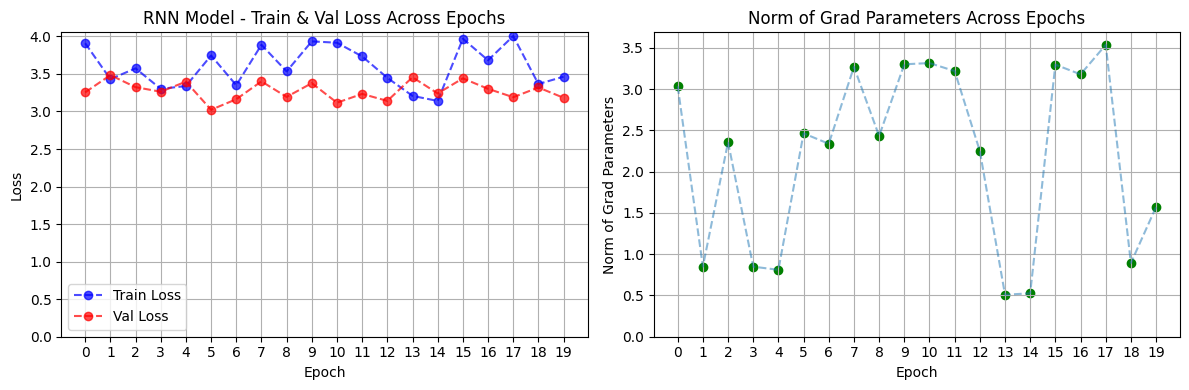

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('RNN Model - Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# Plot gradient norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Grad Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_ylim(bottom=0)  # Start y-axis from zero
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Extract metrics

To evaluate how good our model is, let's extract the multi-class accuracy for the RNN model trained earlier.

In [46]:
a = torch.softmax(all_val_preds[0], dim=1)
a

tensor[8, 28] n=224 x∈[0.001, 0.312] μ=0.036 σ=0.041

In [53]:
a[0].v

tensor[28] x∈[0.001, 0.059] μ=0.036 σ=0.015
tensor([0.0411, 0.0545, 0.0400, 0.0411, 0.0588, 0.0238, 0.0309, 0.0499, 0.0411,
        0.0411, 0.0411, 0.0411, 0.0411, 0.0174, 0.0109, 0.0559, 0.0013, 0.0411,
        0.0411, 0.0034, 0.0411, 0.0411, 0.0176, 0.0411, 0.0411, 0.0198, 0.0411,
        0.0411])

In [ ]:
val_classes = torch.cat(all_val_preds).softmax(dim=1).argmax(dim=1)


tensor[5426] i64 42Kb x∈[0, 27] μ=14.170 σ=10.452
tensor([27,  4, 25,  ..., 10,  3, 18])

In [82]:
matches = val_classes == val_y
val_accuracy = matches.sum() / len(matches)
val_accuracy

tensor 0.187

We can now take this code and integrate it into our training loop!

# Let's change the model to an LSTM!

In [94]:
class LSTMTextClassifier(torch.nn.Module):
    def __init__(self, vocab_size, emb_sz, hidden_dim, num_layers, num_classes, dropout_rate=0.5):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_sz, padding_idx=0)
        self.dropout1  = torch.nn.Dropout(p=dropout_rate)
        self.lstm = torch.nn.LSTM(emb_sz, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.5 if num_layers > 1 else 0, bidirectional=True)
        self.fc       = torch.nn.Linear(hidden_dim * 2, num_classes, bias=True)
        self.dropout2  = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)      # x shape: (batch_size, seq_len, emb_sz)
        x = self.dropout1(x)       # x shape: (batch_size, seq_len, emb_sz)
        
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x) # hidden shape: (batch_size, emb_sz, hidden_dim)

        # h_n[0] contains the forward direction hidden state
        # h_n[1] contains the backward direction hidden state
        # Let's concatenate for a better representation
        last_hidden = torch.cat([h_n[0], h_n[1]], dim=1) # last_hidden shape: (batch_size, hidden_dim * 2)

        # FFNs
        o = self.fc(last_hidden)  # last_hidden shape: (batch_size, num_classes)
        o = self.dropout2(o)           # o shape: (batch_size, num_classes)
        return o


In [ ]:
from datetime import datetime

w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
model = LSTMTextClassifier(vocab_size, emb_sz, hidden_dim, num_layers, num_classes)
criterion = torch.nn.CrossEntropyLoss() # using cross-entropy loss as we're treating this as a multi-class classification problem
# criterion = torch.nn.BCEWithLogitsLoss() # if multi-label :)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 20
epoch_start_time = 0.0

for i in range(n_epochs):
    
    total_train_batches = 0
    total_train_loss = 0
    avg_train_loss = 0.0
    epoch_start_time = datetime.now()

    for batch_x, batch_y in train_dataloader:
        y_pred = model(batch_x)

        loss = criterion(y_pred, batch_y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()

        # update the weights by a small amount
        optimizer.step()

        # print(f" epoch: {i:03d}/{n_epochs:03d} | batch: {b:03d}/train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")
        
        total_train_batches += 1
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / total_train_batches

    # eval
    total_val_batches = 0
    total_val_loss = 0
    all_val_preds = []

    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            val_preds = model(batch_x)

            val_loss = criterion(val_preds, batch_y)
            total_val_loss += val_loss.item()
            total_val_batches += 1
            all_val_preds.append(val_preds)

    avg_val_loss = total_val_loss / total_val_batches

    all_w_params = torch.cat([p.data.view(-1) for p in model.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in model.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_classes = torch.cat(all_val_preds).softmax(dim=1).argmax(dim=1)
    val_matches = val_classes == val_y
    val_accuracy = val_matches.sum() / len(val_matches)

    epoch_duration = (datetime.now() - epoch_start_time).total_seconds()
    print(
        f" epoch: {i:03d}/{n_epochs:03d} |"
        f" duration: {epoch_duration: 3.3f}s |"
        f" train_loss: {avg_train_loss: 3.4f} |"
        f" val_loss: {avg_val_loss: 3.4f} |"
        f" val_accuracy: {val_accuracy: .3f}"
    )


 epoch: 000/020 | duration:  15.877s | train_loss:  3.077010 | val_loss:  3.020687 | val_accuracy:  0.181
 epoch: 001/020 | duration:  15.893s | train_loss:  3.008053 | val_loss:  3.007996 | val_accuracy:  0.182
 epoch: 002/020 | duration:  15.857s | train_loss:  2.989784 | val_loss:  2.969566 | val_accuracy:  0.203
 epoch: 003/020 | duration:  15.822s | train_loss:  2.983996 | val_loss:  2.966901 | val_accuracy:  0.196
 epoch: 004/020 | duration:  15.826s | train_loss:  2.961207 | val_loss:  2.947703 | val_accuracy:  0.202
 epoch: 005/020 | duration:  15.698s | train_loss:  2.951521 | val_loss:  2.945924 | val_accuracy:  0.207
 epoch: 006/020 | duration:  15.798s | train_loss:  2.943713 | val_loss:  2.946738 | val_accuracy:  0.200
 epoch: 007/020 | duration:  15.718s | train_loss:  2.936086 | val_loss:  2.938229 | val_accuracy:  0.199
 epoch: 008/020 | duration:  15.661s | train_loss:  2.925250 | val_loss:  2.908958 | val_accuracy:  0.211
 epoch: 009/020 | duration:  15.951s | train_l

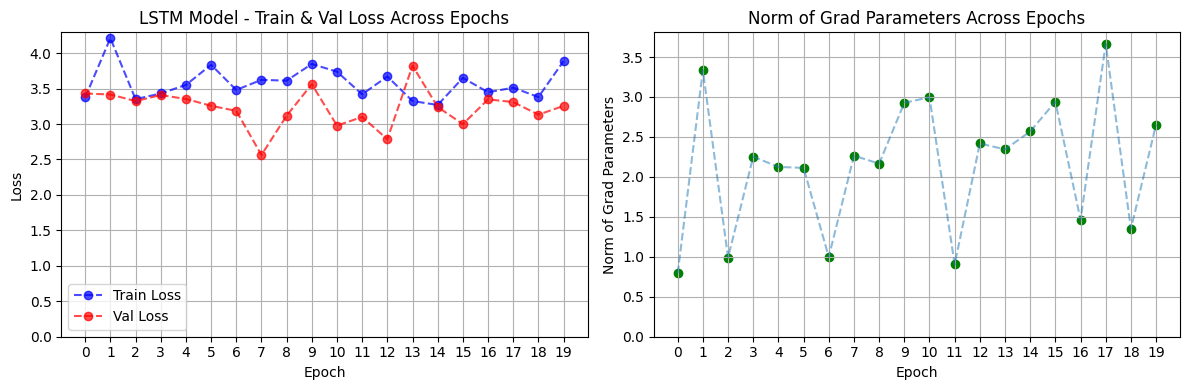

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('LSTM Model - Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# Plot gradient norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Grad Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_ylim(bottom=0)  # Start y-axis from zero
axes[1].grid(True)

plt.tight_layout()
plt.show()


# Let's change the model to a GRU!

GRUs are another form of RNNs which are more effective at handling the vanishing gradient problem!

They are faster to train than LSTMs and require less memory.

They are also sensitive to dropout and hence dropout is recommended only if there are many hidden layers.

In [99]:
class GRUTextClassifier(torch.nn.Module):
    def __init__(self, vocab_size, emb_sz, hidden_dim, num_layers, num_classes, dropout_rate=0.5):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_sz, padding_idx=0)
        self.dropout1  = torch.nn.Dropout(p=dropout_rate)
        self.gru = torch.nn.GRU(input_size=emb_sz, hidden_size=hidden_dim, num_layers=1, batch_first=True, dropout=0.5 if num_layers > 1 else 0, bidirectional=True)
        self.fc       = torch.nn.Linear(hidden_dim * 2, num_classes, bias=True) # * 2 because we are using a bidirectional GRU
        self.dropout2  = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        x = self.embedding(x)      # x shape: (batch_size, seq_len, emb_sz)
        x = self.dropout1(x)       # x shape: (batch_size, seq_len, emb_sz)
        
        # GRU forward pass
        gru_out, hidden = self.gru(x)
        # gru_out shape: (batch_size, seq_len, hidden_dim * 2)
        # hidden shape: (num_layers * 2, batch_size, hidden_dim)

        # For bidirectional GRU with 1 hidden layer:
        # Concat the two
        last_hidden = torch.cat([hidden[0], hidden[1]], dim=1) # last_hidden shape: (batch_size, hidden_dim * 2)

        # FFNs
        o = self.fc(last_hidden)  # last_hidden shape: (batch_size, num_classes)
        o = self.dropout2(o)           # o shape: (batch_size, num_classes)
        return o


In [100]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
model = GRUTextClassifier(vocab_size, emb_sz, hidden_dim, num_layers, num_classes)
criterion = torch.nn.CrossEntropyLoss() # using cross-entropy loss as we're treating this as a multi-class classification problem
# criterion = torch.nn.BCEWithLogitsLoss() # if multi-label :)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

n_epochs = 20
for i in range(n_epochs):
    
    total_train_batches = 0
    total_train_loss = 0
    avg_train_loss = 0.0
    epoch_start_time = datetime.now()

    for batch_x, batch_y in train_dataloader:
        y_pred = model(batch_x)

        loss = criterion(y_pred, batch_y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backward pass
        loss.backward()

        # update the weights by a small amount
        optimizer.step()

        # logging
        total_train_batches += 1
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / total_train_batches
    
    # eval
    total_val_batches = 0
    total_val_loss = 0
    all_val_preds = []

    with torch.no_grad():
        for batch_x, batch_y in val_dataloader:
            val_preds = model(batch_x)

            val_loss = criterion(val_preds, batch_y)
            total_val_loss += val_loss.item()
            total_val_batches += 1
            all_val_preds.append(val_preds)

    avg_val_loss = total_val_loss / total_val_batches

    all_w_params = torch.cat([p.data.view(-1) for p in model.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in model.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_classes = torch.cat(all_val_preds).softmax(dim=1).argmax(dim=1)
    val_matches = val_classes == val_y
    val_accuracy = val_matches.sum() / len(val_matches)

    epoch_duration = (datetime.now() - epoch_start_time).total_seconds()
    print(
        f" epoch: {i:03d}/{n_epochs:03d} |"
        f" duration: {epoch_duration: 3.3f}s |"
        f" train_loss: {avg_train_loss: 3.4f} |"
        f" val_loss: {avg_val_loss: 3.4f} |"
        f" val_accuracy: {val_accuracy: .3f}"
    )

 epoch: 000/020 | duration:  16.236s | train_loss:  3.0782 | val_loss:  3.0338 | val_accuracy:  0.178
 epoch: 001/020 | duration:  16.235s | train_loss:  2.9994 | val_loss:  3.0093 | val_accuracy:  0.182
 epoch: 002/020 | duration:  16.334s | train_loss:  2.9811 | val_loss:  2.9769 | val_accuracy:  0.194
 epoch: 003/020 | duration:  16.118s | train_loss:  2.9590 | val_loss:  2.9605 | val_accuracy:  0.195
 epoch: 004/020 | duration:  16.217s | train_loss:  2.9423 | val_loss:  2.9574 | val_accuracy:  0.198
 epoch: 005/020 | duration:  16.204s | train_loss:  2.9347 | val_loss:  2.9325 | val_accuracy:  0.200
 epoch: 006/020 | duration:  16.386s | train_loss:  2.9224 | val_loss:  2.9315 | val_accuracy:  0.202
 epoch: 007/020 | duration:  16.181s | train_loss:  2.9038 | val_loss:  2.9034 | val_accuracy:  0.215
 epoch: 008/020 | duration:  16.288s | train_loss:  2.8957 | val_loss:  2.8982 | val_accuracy:  0.216
 epoch: 009/020 | duration:  16.316s | train_loss:  2.8861 | val_loss:  2.8764 | v

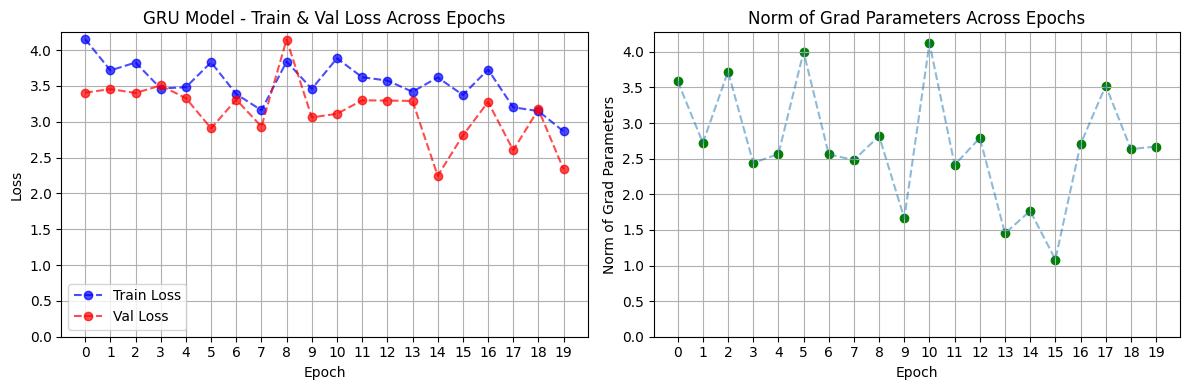

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = list(range(n_epochs))

# Plot train and val loss on the same plot
axes[0].plot(epochs, losses, label='Train Loss', color='blue', marker='o', linestyle='dashed', alpha=0.7)
axes[0].plot(epochs, val_losses, label='Val Loss', color='red', marker='o', linestyle='dashed', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('GRU Model - Train & Val Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_ylim(bottom=0)  # Start y-axis from zero
axes[0].grid(True)
axes[0].legend()

# Plot gradient norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Grad Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_ylim(bottom=0)  # Start y-axis from zero
axes[1].grid(True)

plt.tight_layout()
plt.show()


The downward curve on val loss is encouraging!

Our accuracy is low as the model has to learn classifying just from the training text. The model does not know anything about the world. When we switch to pretrained models, the model performance should be higher!